In [ ]:
pip install torch torchaudio matplotlib pydub openai-whisper


Saving audio_data.m4a to audio_data (1).m4a
Uploaded: audio_data (1).m4a
Converted to: converted.wav
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Detected 4 speech segments.
[{'start': 37408, 'end': 65504}, {'start': 109600, 'end': 119776}, {'start': 131104, 'end': 144352}, {'start': 153632, 'end': 165344}]


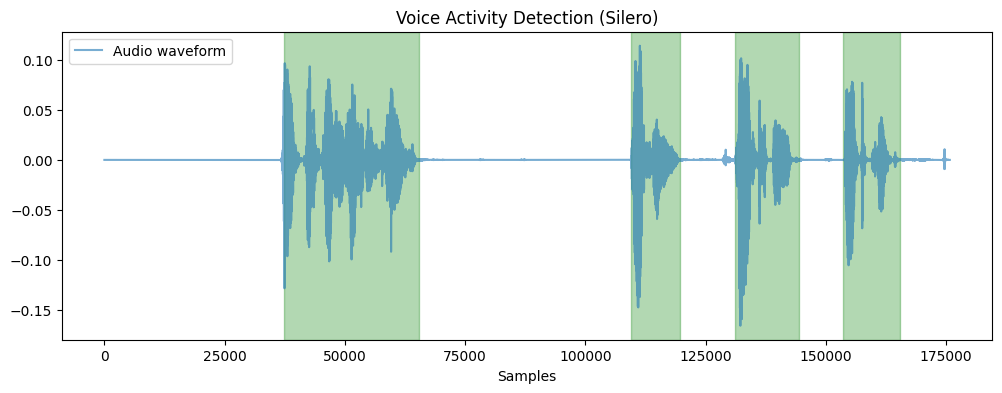

Extracted speech saved as: speech_only.wav


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display
import whisper

from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"Uploaded: {file_name}")


audio = AudioSegment.from_file(file_name, format="m4a")
wav_path = "converted.wav"
audio.export(wav_path, format="wav")
print(f"Converted to: {wav_path}")

model, utils = torch.hub.load('snakers4/silero-vad', 'silero_vad', force_reload=True)
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

wav, sr = torchaudio.load(wav_path)
if wav.shape[0] > 1:
    wav = torch.mean(wav, dim=0, keepdim=True)

wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000).squeeze()
sr = 16000

speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sr)
print(f"Detected {len(speech_timestamps)} speech segments.")
print(speech_timestamps[:5])

plt.figure(figsize=(12, 4))
plt.plot(wav.numpy(), alpha=0.6, label="Audio waveform")

for ts in speech_timestamps:
    plt.axvspan(ts['start'], ts['end'], color='green', alpha=0.3)

plt.title("Voice Activity Detection (Silero)")
plt.xlabel("Samples")
plt.legend()
plt.show()

speech = collect_chunks(speech_timestamps, wav)
torchaudio.save("speech_only.wav", speech.unsqueeze(0), sr)

print("Extracted speech saved as: speech_only.wav")
display(Audio("speech_only.wav"))


In [ ]:
whisper_model = whisper.load_model("tiny")

transcripts = []
for i, ts in enumerate(speech_timestamps):
    start, end = ts['start'], ts['end']
    segment = wav[start:end]
    temp_path = f"segment_{i}.wav"
    torchaudio.save(temp_path, segment.unsqueeze(0), sr)

    result = whisper_model.transcribe(temp_path, language="en")
    transcripts.append(result["text"])
    print(f"[Segment {i+1}] {result['text']}")

full_text = " ".join(transcripts)
print("\n--- FULL TRANSCRIPTION ---\n")
print(full_text)

/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[Segment 1]  like the same one to three.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 2]  Marguer.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 3]  Marguer to


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 4]  Mark III.

--- FULL TRANSCRIPTION ---

 like the same one to three.  Marguer.  Marguer to  Mark III.


In [ ]:
!pip install transformers --quiet
from transformers import MarianMTModel, MarianTokenizer

target_lang = "hi"
model_name = f"Helsinki-NLP/opus-mt-en-{target_lang}"


tokenizer = MarianTokenizer.from_pretrained(model_name)
translation_model = MarianMTModel.from_pretrained(model_name)

print("Translating...")
batch = tokenizer([full_text], return_tensors="pt", padding=True)
translated_tokens = translation_model.generate(**batch, max_length=512)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print(f"\n--- Translated ({target_lang}) ---\n")
print(translated_text)

Translating...

--- Translated (hi) ---

वही तीन में से तीन को. मारमूर. मार्क III के लिए मार्कर.


In [ ]:
!pip install transformers torchaudio soundfile --quiet
from transformers import AutoProcessor, BarkModel
import torch, soundfile as sf
from IPython.display import Audio, display
import numpy as np
import soundfile as sf
model_name = "suno/bark-small"
processor = AutoProcessor.from_pretrained(model_name)
model = BarkModel.from_pretrained(model_name)

voice_preset = "v2/hi_speaker_4"

inputs = processor(translated_text, voice_preset=voice_preset, return_tensors="pt")
speech = model.generate(**inputs)
speech_np = speech.squeeze().cpu().numpy().astype(np.float32)

sf.write("hindi_bark.wav", speech_np, 22050)
print(speech_np.shape, speech_np.dtype, speech_np.min(), speech_np.max())

print("Dubbed speech saved as hindi_bark.wav")
display(Audio("hindi_bark.wav"))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


(116800,) float32 -1.6918421 1.6149454
Dubbed speech saved as hindi_bark.wav
